In [44]:
import os
import random

def get_random_image_from_subfolders(root_folder):
    # Lấy danh sách các thư mục con
    subfolders = [os.path.join(root_folder, d) for d in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, d))]
    
    # Chọn một thư mục con ngẫu nhiên
    random_subfolder = random.choice(subfolders)
    
    # Lấy danh sách các tệp trong thư mục con đã chọn
    images = [os.path.join(random_subfolder, f) for f in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, f))]
    
    # Chọn một ảnh ngẫu nhiên
    random_image = random.choice(images)
    
    return random_image

# Đường dẫn tới thư mục gốc chứa thư mục ảnh
root_folder = '/kaggle/input/data-test/Test/frames'

# Lấy ảnh ngẫu nhiên
random_image = get_random_image_from_subfolders(root_folder)
print("Ảnh ngẫu nhiên:", random_image)

Ảnh ngẫu nhiên: /kaggle/input/data-test/Test/frames/L02_V030/616.jpg


## Test dùng facebook research

In [45]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [46]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [47]:
# standard PyTorch mean-std input image normalization
transform = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.ToTensor(),
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [48]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [49]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


In [50]:
im = Image.open(random_image)

In [51]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

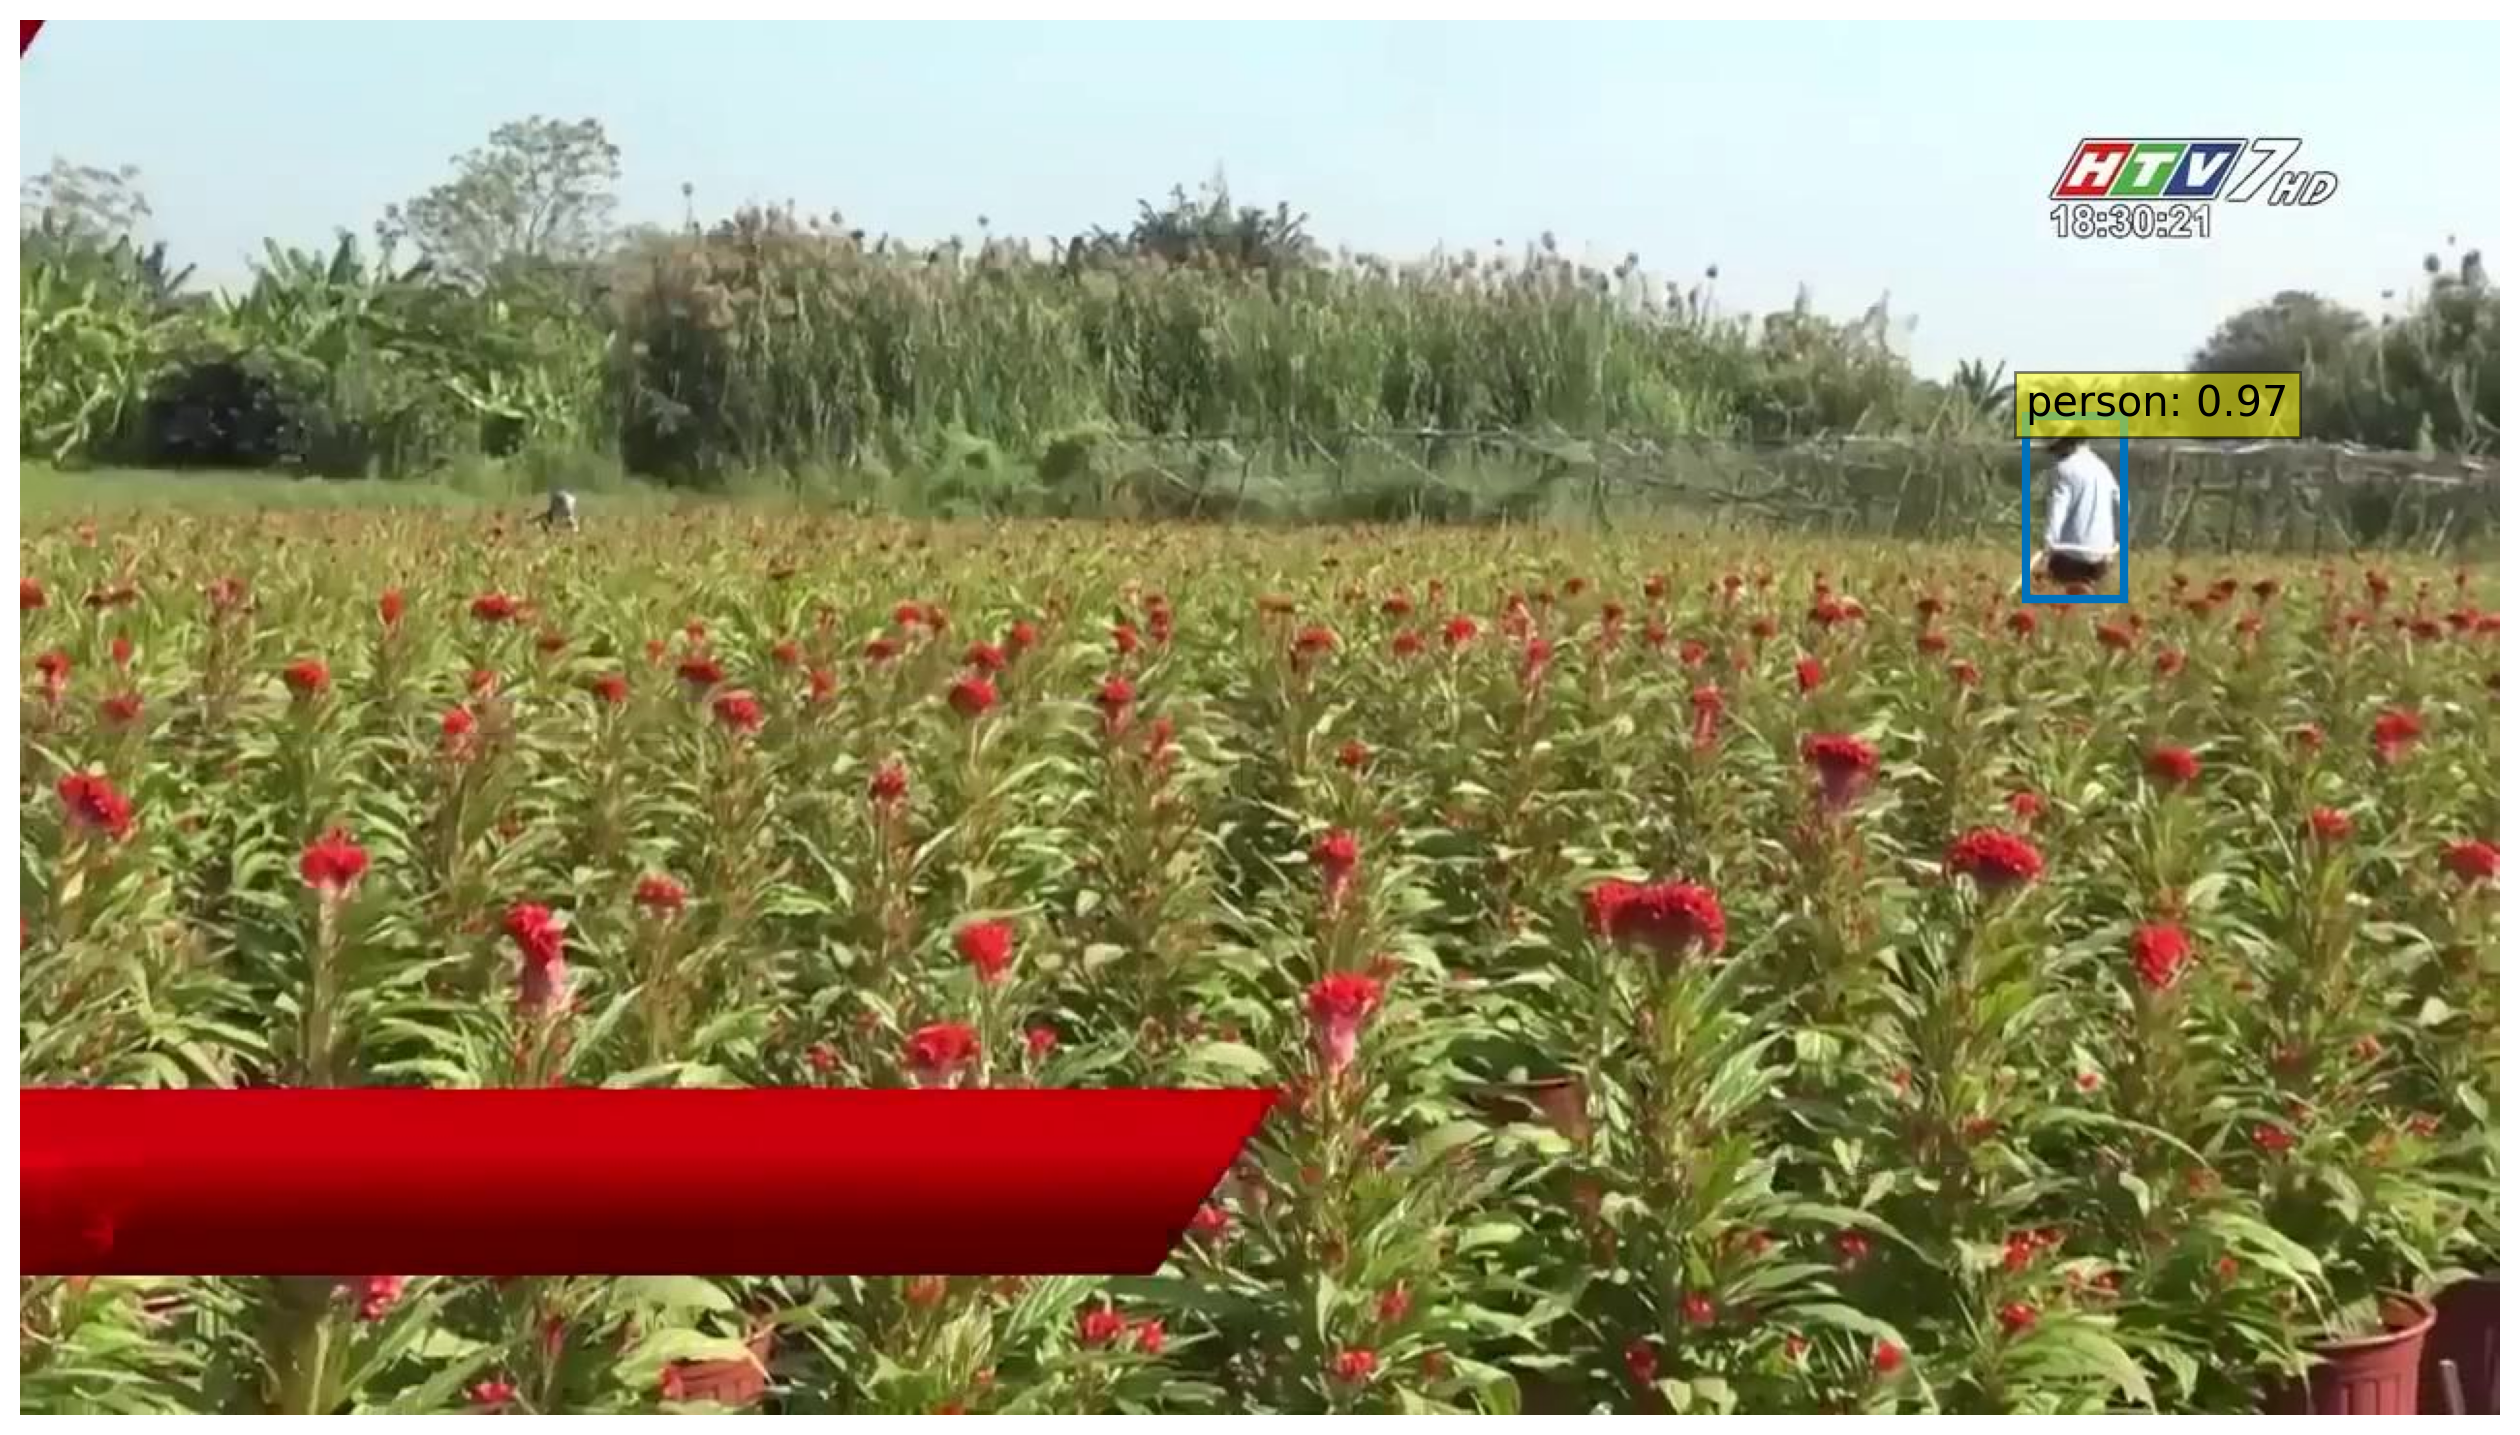

In [52]:
plot_results(im, probas[keep], bboxes_scaled)

In [53]:
!pip install ultralytics
!pip install matplotlib

## Dùng YOLO



0: 640x480 1 bird, 15.1ms
Speed: 1.0ms preprocess, 15.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)


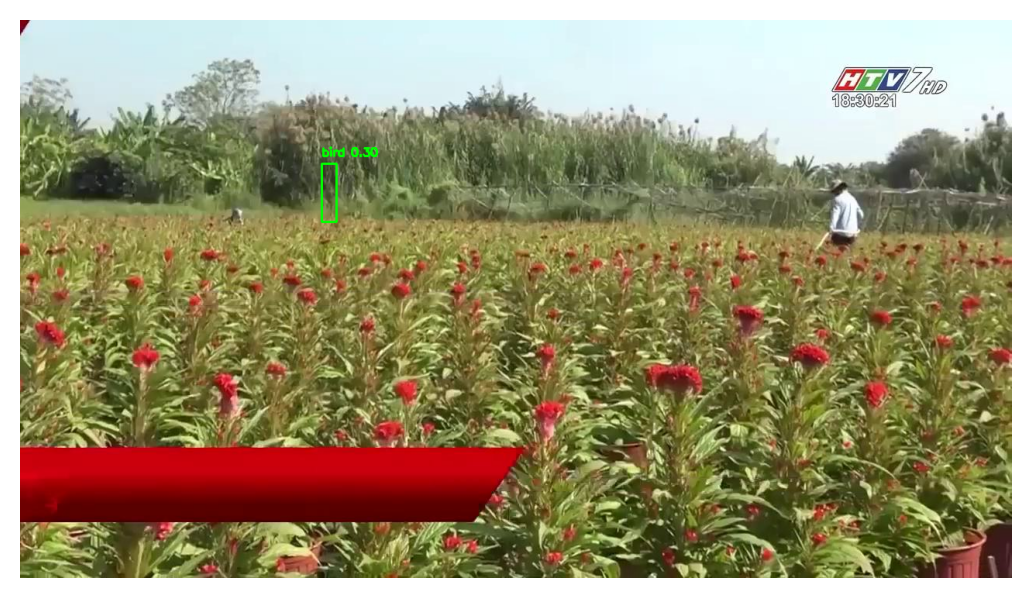

In [54]:
from ultralytics import YOLO
import cv2
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def detect_and_draw(image_path, model, output_path=None):
    # Định nghĩa các phép biến đổi cho ảnh
    transform = transforms.Compose([
        transforms.Resize((640, 480)),
        transforms.ToTensor(),
    ])

    # Đọc và chuyển đổi ảnh thành tensor
    img = cv2.imread(image_path)
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    img_tensor = transform(img_pil).unsqueeze(0)  # Thêm một chiều batch

    # Thực hiện phát hiện đối tượng với model
    results = model(img_tensor)

    # Xử lý từng kết quả phát hiện trong ảnh
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        score = float(box.conf[0])
        class_id = int(box.cls[0])
        class_name = model.names[class_id]

        # Vẽ bounding box lên ảnh
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{class_name} {score:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Lưu ảnh kết quả hoặc hiển thị với Matplotlib
    if output_path:
        cv2.imwrite(output_path, img)
        print(f"Ảnh kết quả đã được lưu tại: {output_path}")
    else:
        # Chuyển đổi sang định dạng RGB cho Matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

# Tải mô hình từ tệp .pt
model = YOLO('/kaggle/input/data-test/Test/yolov8m.pt')

# Gọi hàm với mô hình đã tải và đường dẫn đến ảnh của bạn
detect_and_draw(random_image, model)
